<a href="https://colab.research.google.com/github/Aron9605/Quantum-repetition-code/blob/main/Repetition_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Break-even point of the quantum repetition code

---



In this notebook, we investigate when the phase-flip repetition code is getting more advantageous than a single physical qubit against a certain noise model.

We study the repetition code under realistic noise models such as relaxation (T_1) and dephasing (T_2). The density matrix time-evolution is described by Kraus formalism.

We derive a break-even point, above which the repetition code is  effective and preserves arbitrary quantum data even longer than a single qubit lifetime. 


## Definitions

In [2]:
import numpy as np
import sympy as sym
from sympy.plotting import *
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot
FU = sym.FU

%matplotlib inline

In [3]:
# Define CNOT matrix - CNOT(index-of-control-qubit, index-of-target-qubit)

N = 3
basis = [[i, j, k] for i in range(2) for j in range(2) for k in range(2)]
basisS = ['|{}{}{}>'.format(i, j, k) for i, j, k in basis]

def CNOTket(i, j, lst):
    output = list(lst)
    if lst[i] == 0:
        return output
    else:
        output[j] = 1 - output[j]
        return output
    
def CNOT(i,j):
    mtx = np.zeros((2**N, 2**N))
    pos = []
    for n in range(len(basis)):
        pos.append([n, basis.index(CNOTket(i,j,basis[n]))])
    for i, j in pos:
        mtx[i][j] = 1
    return(mtx)

# Define Toffolo-gate -- TOFF(index-of-control-qubit1, index-of-control-qubit2, index-of-target-qubit)

def TOFket(i, j, k, lst):
    out = list(lst)
    if lst[i] == 0 or lst[j] == 0:
        return out
    else:
        out[k] = 1 - out[k]
        return out

def TOFF(i, j, k):
    mtx = np.zeros((2**N, 2**N))
    pos = []
    for n in range(len(basis)):
        pos.append([n, basis.index(TOFket(i,j,k,basis[n]))])
    for i, j in pos:
        mtx[i][j] = 1
    return(mtx)

In [4]:
# Symbols

alpha = sym.Symbol('alpha', real=True)
gamma = sym.Symbol('gamma', real=True)
th = sym.Symbol('theta', real=True)
phi = sym.Symbol('phi', real=True)
t = sym.Symbol('t', real=True, positive=True)
T1 = sym.Symbol('T1', real=True, positive=True)
T2 = sym.Symbol('T2', real=True, positive=True)
T2s = sym.Symbol('T2s', real=True, positive=True)


# Pauli matrices 

s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

# Hadamard gate
h = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
had = np.kron(h, np.kron(h,h)) # 3qubit operator

# Kraus-operators of amplitude and phase damping

K1phase = np.array([[sym.sqrt(1-alpha),0],[0,sym.sqrt(1-gamma)]])
K2phase = np.array([[sym.sqrt(alpha),0],[0,0]])
K2relax = np.array([[0,sym.sqrt(gamma)],[0,0]])

Kraus_list = np.array([K1phase, K2phase, K2relax])

# basis states 

p = 1/np.sqrt(2)*np.array([1,1]) # State |+>
m = 1/np.sqrt(2)*np.array([1,-1]) # State |->

## Single qubit fidelity

In [22]:
# Idle qubit

psi_init = sym.Array([sym.cos(th/2), sym.sin(th/2)*sym.exp(sym.I*phi)]) #arbitrary initial state - quantum t-design
rho_0 = np.outer(psi_init, np.conjugate(psi_init)) #belonging density matrix

#describe the time-evolution of density matrix by Krause operators
#np.matrix.getH() - conjugate transpose
krs=[]
for i in Kraus_list:
    #krs.append(np.dot(i,np.dot(rho_0,np.matrix.getH(i))))
    krs.append(np.linalg.multi_dot([i, rho_0, np.matrix.getH(i)]))
    
    
s=np.zeros((2, 2))
for i in krs:
    s = np.add(i,s)

rho_t = s #time evolution of density matrix that contains the effect of noises

In [23]:
#to quantify the effect of noise on the state, we calculate the averaged fidelity = integrate the state over the bloch spehere
fid = 1/(4*np.pi)*np.dot(np.conjugate(psi_init), np.dot(rho_t, psi_init))*sym.sin(th)

In [24]:
fid1 = FU['TR0'](FU['TR8'](fid))

In [25]:
intr = sym.integrate(fid1, (th, 0, np.pi), (phi, 0, 2*np.pi))

In [26]:
#gamma = 1-sym.exp(-t/T1)
#alpha = 1-sym.exp(-2*t/T2s)
#T2s = 2*T1*T2/(2*T1-T2)

fid_idle = intr.subs(gamma, 1-sym.exp(-t/T1)).subs(alpha, 1-sym.exp(-2*t/T2s)).subs(T2s, 2*T1*T2/(2*T1-T2))

In [60]:
'''fidelity of a single qubit'''
print(sym.factor_terms(sym.nsimplify(sym.simplify(fid_idle))))

(3 + 2*exp(-t/T2) + exp(-t/T1))/6


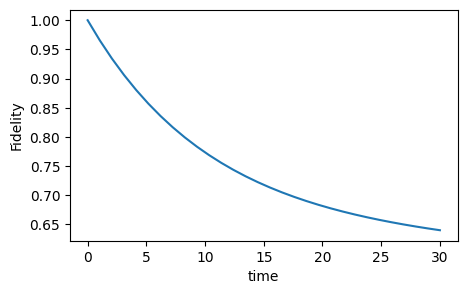

In [28]:
lam_f = sym.lambdify(t, fid_idle.subs(T1, 100).subs(T2, 10), modules=['numpy'])

t_vals = np.linspace(0, 30, 30)
f_vals = lam_f(t_vals)

plt.figure(figsize=(5,3))
plt.plot(t_vals, f_vals)
plt.ylabel("Fidelity")
plt.xlabel("time")
plt.show()

## **3-qubit fidelity** - phase-flip code

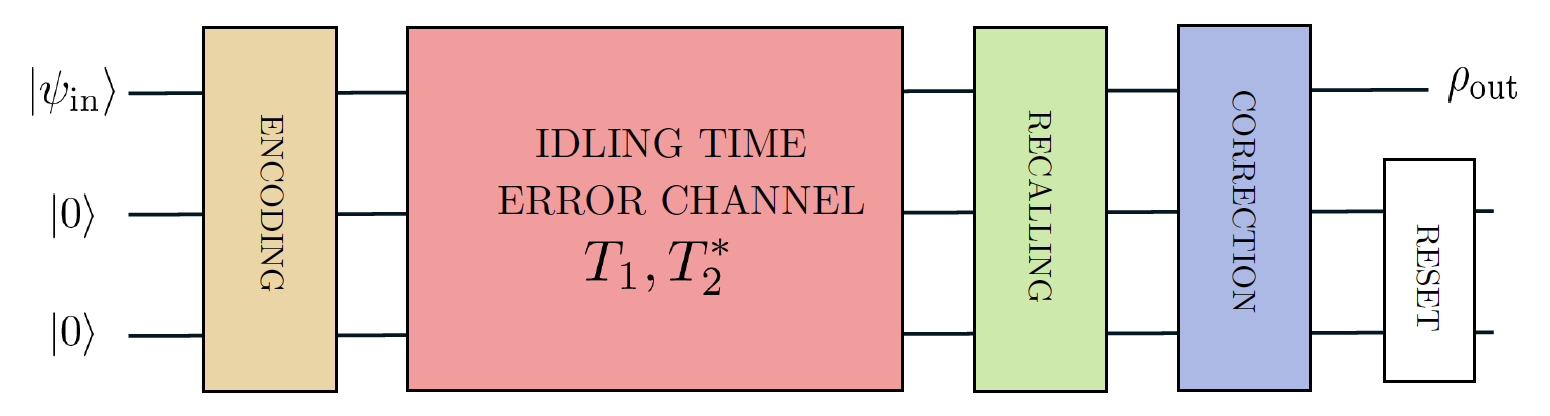

In [29]:
#initial 3-qubit denisty matrix
rho_init = np.kron(np.outer(psi_init, np.conjugate(psi_init)), np.kron(np.outer(np.array([1,0]), np.conjugate(np.array([1,0]))),np.outer(np.array([1,0]), np.conjugate(np.array([1,0])))))

In [78]:
#encoding the arbitrary quantum information into 3-qubit state by cnot gates
rho_enc = np.linalg.multi_dot([CNOT(0,2), CNOT(0,1), rho_init, CNOT(0,1), CNOT(0,2)])

In [79]:
#applying Hadamards on each qubits
rho_H = np.linalg.multi_dot([had, rho_enc, had])

In [95]:
#time-evoluiton of 3-qubit density matrix described by Kraus operators acting on each qubits independently
krs3=[]
for i in Kraus_list:
    for j in Kraus_list:
        for k in Kraus_list:
            krs3.append(np.dot(np.kron(i, np.kron(j, k)), np.dot(rho_H, np.matrix.getH(np.kron(i, np.kron(j, k))))))
                
er = np.zeros((8, 8))
for i in krs3:
    er = np.add(i,er)

rho_t3 = er

In [80]:
#applying Hadamards on each qubits
rho_Hinv = np.linalg.multi_dot([had, rho_t3, had])

In [81]:
#recalling the information into 1 qubit state and using the states of the remaining qubits as syndromes for error correction
rho_recall = np.linalg.multi_dot([CNOT(0,2), CNOT(0,1), rho_Hinv, CNOT(0,1), CNOT(0,2)])

In [83]:
#Toffoli gates performes error correction 
rho_cor = np.linalg.multi_dot([TOFF(1,2,0), rho_recall, np.matrix.getH(TOFF(1,2,0))])

In [84]:
#traceing out the ancillary qubits
rho_traced=np.trace(np.trace(rho_cor.reshape([2,2,2,2,2,2]), axis1=1, axis2=4), axis1=1, axis2=3) #partial trace of q2(m,m) and q3(k,k); shape(n,m,k,n,m,k)

In [85]:
#to quantify the efficiency of the error correction scheme, we calculate the averaged fidelity
fid3 = np.linalg.multi_dot([np.conjugate(psi_init), rho_traced, psi_init])

In [86]:
#fidelity is calculated in 6 cardinal points of the bloch spehere and averaged it out
#it is identical with the integration

# six cardinal points of the Bloch sphere
print(psi_init.subs(th, 0).subs(phi, 2*sym.pi))
print(psi_init.subs(th, sym.pi).subs(phi, 0))
print(psi_init.subs(th, sym.pi/2).subs(phi, sym.pi))
print(psi_init.subs(th, sym.pi/2).subs(phi, 0))
print(psi_init.subs(th, sym.pi/2).subs(phi, sym.pi/2))
print(psi_init.subs(th, sym.pi/2).subs(phi, -1*sym.pi/2))

[1, 0]
[0, 1]
[sqrt(2)/2, -sqrt(2)/2]
[sqrt(2)/2, sqrt(2)/2]
[sqrt(2)/2, sqrt(2)*I/2]
[sqrt(2)/2, -sqrt(2)*I/2]


In [87]:
intr3 = 1/6*(fid3.subs(th, 0).subs(phi, 2*np.pi) + fid3.subs(th, np.pi).subs(phi, 0) + fid3.subs(th, np.pi/2).subs(phi, np.pi) + fid3.subs(th, np.pi/2).subs(phi, 0) + fid3.subs(th, np.pi/2).subs(phi, np.pi/2) + fid3.subs(th, np.pi/2).subs(phi, -1*np.pi/2))

In [88]:
fid_phase = intr3.subs(gamma, 1-sym.exp(-t/T1)).subs(alpha, 1-sym.exp(-2*t/T2s)).subs(T2s, 2*T1*T2/(2*T1-T2))

In [89]:
#nsimplify(fid_phase,tolerance=1e-5, full=True)

In [90]:
#chopping zero terms

ex=fid_phase.xreplace(dict([(n,0) for n in fid_phase.atoms(sym.Float) if abs(n) < 1e-12]))

In [91]:
ex2=sym.simplify(ex.evalf())

In [92]:
ex3=ex2.xreplace(dict([(n,0) for n in ex2.atoms(sym.Float) if abs(n) < 1e-12]))

In [93]:
ex3 = sym.factor_terms(sym.nsimplify(ex3))

In [94]:
'''fidelity of 3-qubit phase-flip code'''
print(ex3)

(6 + 3*exp(-t*(1/T2 + 2/T1)) + 3*exp(-t/T2) - 2*exp(-3*t/T2) + 2*exp(-3*t/T1))/12


In [96]:
# break-even point: code fidelity > single qubit fidelity

tay_i = sym.factor_terms(sym.nsimplify(sym.series(fid_idle, t, 0, 2))).removeO()
tay_p = sym.factor_terms(sym.series(ex3, t, 0, 2)).removeO()

In [52]:
print(tay_i)
print(tay_p.evalf())

-t*(2/T2 + 1/T1)/6 + 1
1.0 - t/T1


In [54]:
from sympy import reduce_inequalities
eq = reduce_inequalities(tay_p > tay_i, [t])

In [55]:
eq.subs(T2,2*T1*T2s/(2*T1+T2s)).simplify()

t*(T1 - 2*T2s)/(3*T1*T2s) > 0

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


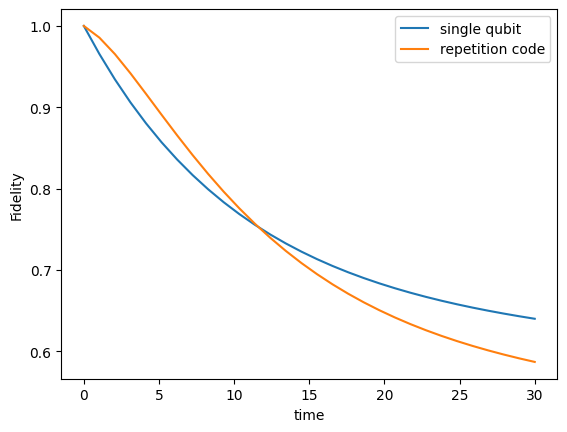

In [56]:
'''plotting a specific scenario when repetition code is beneficial (T1>2T2*) up to a treshold t time'''

lam_f3 = sym.lambdify(t, fid_phase.subs(T1, 100).subs(T2, 10), modules=['numpy'])

t_vals = np.linspace(0, 30, 30)
f_vals3 = lam_f3(t_vals)

plt.plot(t_vals, f_vals)
plt.plot(t_vals, f_vals3)
plt.ylabel("Fidelity")
plt.xlabel("time")
plt.legend(['single qubit', 'repetition code'])
plt.show()